# RA and Dec measurement repeatability in multiple visits on HSC precursor data

is between 5 and 10 mas for g-band in tract 9813 with 17 overlapping visits. 

In [1]:
from lsst.daf.butler import Butler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

In [2]:
butler = Butler('/repo/main', collections=['HSC/runs/RC2/w_2023_50/DM-42194'])

In [3]:
# read in the n-way matched bright isolated point sources
# This is the dataset we use for fitting astrometry etc...
isolated_star_sources = butler.get("isolated_star_sources", skymap="hsc_rings_v1", tract=9813)
isolated_star_sources.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,244632,527619552446040,1228,92,150.129075,2.743438,HSC-I,i,8133.591797,632.296448,2004.000408,3641.778809,6822.989223,898.264517,False,-1.185561,False,244632,0
1,241784,528480693387294,1230,93,150.129064,2.743446,HSC-I,i,8351.114258,641.694214,1068.663368,70.778924,7616.517079,915.194695,False,-0.776985,False,241784,0
2,239371,529326801945109,1232,87,150.129053,2.743435,HSC-I,i,7733.971680,623.501404,344.758315,974.894071,6565.768755,889.012677,False,-0.106671,False,239371,0
3,254977,531901634840734,1238,86,150.129056,2.743442,HSC-I,i,9163.507812,654.370667,71.158995,4009.655972,8916.701934,933.057782,False,0.069349,False,254977,0
4,238639,532775660683470,1240,93,150.129062,2.743433,HSC-I,i,9112.935547,680.429810,1260.889434,441.888885,7438.498795,967.657478,False,-0.819285,False,238639,0


In [4]:
# get the list of g-band visits so we can read in the final source tables with the best-fit positions
visits = isolated_star_sources[isolated_star_sources.band == "g"].visit.unique()
print(visits)

[11690 11692 11694 11696 11698 11700 11702 11704 11706 11708 11710 11712
 29324 29326 29336 29340 29350]


In [5]:
sourceTables = []
for visit in visits:
    sourceTable = butler.get("sourceTable_visit", visit=visit,parameters={"columns": ["sourceId", "ra", "dec", "psfFlux", "psfFluxErr", "pixelFlags_bad", "pixelFlags_saturated", "detect_isPrimary"]})
    sourceTables.append(sourceTable)

sources = pd.concat(sourceTables)
sources.head()

,ra,dec,psfFlux,psfFluxErr,pixelFlags_bad,pixelFlags_saturated,detect_isPrimary
sourceId,,,,,,,
5020816769024001,150.329808,1.490417,325.650576,29.433033,False,False,True
5020816769024002,150.330525,1.530190,328.020805,28.772124,False,False,True
5020816769024003,150.330954,1.542674,266040.801202,276.302641,False,False,False
5020816769024004,150.330549,1.486306,1530.588419,30.765019,False,False,True
5020816769024005,150.330273,1.498560,389.524572,29.243796,False,False,True


In [6]:
# join with the catalog with the associated matches
joined = pd.merge(isolated_star_sources[["sourceId", "obj_index"]], sources, left_on="sourceId", right_index=True)

In [7]:
print("all SNR > ",(joined['psfFlux']/joined['psfFluxErr']).min())

all SNR >  6.309977317510419


Text(0.5, 0, 'PSF Flux SNR')

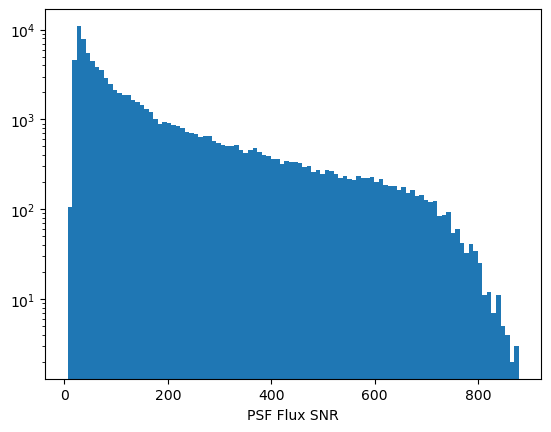

In [8]:
_ = plt.hist(joined['psfFlux']/joined['psfFluxErr'], bins=100, log=True)
plt.xlabel("PSF Flux SNR")

In [9]:
grouped = joined.groupby("obj_index")

results = pd.DataFrame()

# Make a table with various statistics (robust and not) for the scatter of RA and Dec (pick your favorite)
results['ra_std'] = grouped.ra.std()*60*60*1000
results['dec_std'] = grouped.dec.std()*60*60*1000
results['ra_std_percentile'] =  grouped.ra.apply(lambda x: np.percentile(x, 69.1) - np.percentile(x, 30.9))*60*60*1000
results['dec_std_percentile'] =  grouped.dec.apply(lambda x: np.percentile(x, 69.1) - np.percentile(x, 30.9))*60*60*1000
results['ra_std_mad'] =  grouped.ra.apply(lambda x: scipy.stats.median_abs_deviation(x))*1.4826*60*60*1000
results['dec_std_mad'] =  grouped.dec.apply(lambda x: scipy.stats.median_abs_deviation(x))*1.4826*60*60*1000
results['count'] = grouped.dec.count()

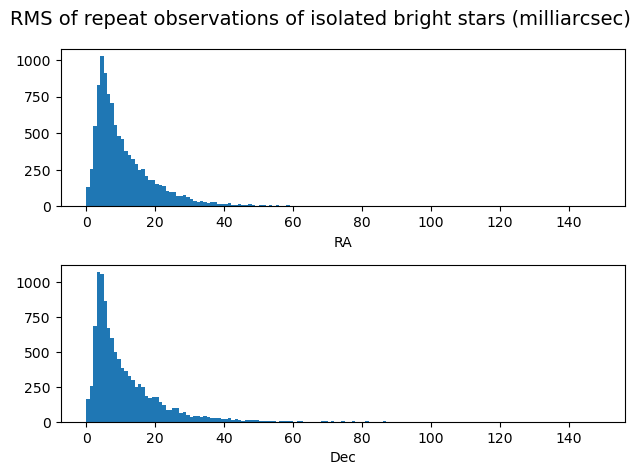

In [13]:
fig = plt.figure()
fig.suptitle('RMS of repeat observations of isolated bright stars (milliarcsec)', fontsize=14)
plt.subplot(211)
_ = plt.hist(results[results['count'] > 1]['ra_std'],  bins=np.arange(0,150), label="raw stdev")
plt.xlabel("RA")
plt.subplot(212)
_ = plt.hist(results[results['count'] > 1]['dec_std'],  bins=np.arange(0,150), label="raw stdev")
plt.xlabel("Dec")
plt.tight_layout()

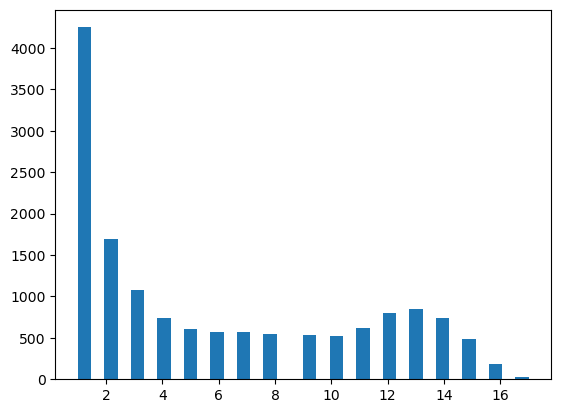

In [11]:
_ = plt.hist(grouped.dec.count(), bins=34)

In [12]:
print(results[results['count'] > 1].ra_std.median(), "Median RA RMS (raw stdev) (milliarcsec)")
print(results[results['count'] > 1].dec_std.median(), "Median Dec RMS (raw stdev) (milliarcsec)")
print(results[results['count'] > 1].ra_std_percentile.median(), "Median RA RMS (percentile range) (milliarcsec)")
print(results[results['count'] > 1].dec_std_percentile.median(), "Median Dec RMS (percentile range) (milliarcsec)")
print(results[results['count'] > 1].ra_std_mad.median(), "Median RA RMS (sigma MAD) (milliarcsec)")
print(results[results['count'] > 1].dec_std_mad.median(), "Median Dec RMS (sigma MAD) (milliarcsec)")

8.210830496038314 Median RA RMS (raw stdev) (milliarcsec)
7.798748786955189 Median Dec RMS (raw stdev) (milliarcsec)
6.267396611292497 Median RA RMS (percentile range) (milliarcsec)
5.870474760705235 Median Dec RMS (percentile range) (milliarcsec)
6.901577058697511 Median RA RMS (sigma MAD) (milliarcsec)
6.590865744596819 Median Dec RMS (sigma MAD) (milliarcsec)
